# 回帰木 (CART) を実装する

---

## 実装してみる

### 必要なパッケージを読み込む

In [1]:
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### 不純度を求める

In [2]:
# 不純度として分散を用いる
calc_variance <-
  function(data) {
    var(data$y)
  }

### 不純度の減り幅を求める

In [3]:
calc_delta <-
  function(data, calc_impurity) {
    values <- unique(data$x)
    thresholds <- (values[2:length(values)] + values[1:(length(values) - 1)]) / 2
    map_df(thresholds, calc_delta.sub, data, calc_impurity)
  }
calc_delta.sub <-
  function(threshold, data, calc_impurity) {
    left <- data %>% filter(x < threshold)
    right <- data %>% filter(threshold <= x)
    delta <- calc_impurity(data) - (nrow(left) / nrow(data)) * calc_impurity(left) - (nrow(right) / nrow(data)) * calc_impurity(right)
    tibble(threshold = threshold, delta = delta)
  }

### 回帰木を作成する

In [4]:
cart <-
  function(data, max_depth, calc_impurity, depth = 0) {
    # 平均を求める
    pred <- mean(data$y)
    
    # 深さが最大値に達した場合、これ以上分割しない
    if (depth == max_depth) {
      return(list(pred = pred))
    }
    # 不純度が0の場合、これ以上分割しない
    if (calc_impurity(data) == 0) {
      return(list(pred = pred))
    }
    
    # 不純度の減り幅が最大となる説明変数と閾値を求める
    node <-
      # 説明変数別に、該当する説明変数と目的変数の2変数かなるデータフレームを作成する
      tibble(variable = setdiff(colnames(data), "y")) %>%
      mutate(data = map(variable, ~ tibble(x = data[[.]], y = data$y))) %>%
      # 説明変数別に、不純度を計算する
      mutate(data = map(data, calc_delta, calc_impurity)) %>%
      # ネストしているデータフレームを展開し、フラットにする
      unnest(cols = c(data)) %>%
      # 不純度の減り幅が最大となる説明変数と閾値を取り出す
      filter(delta == max(delta))
    
    # 子ノードを分割する
    left <- data[data[[node[[1, "variable"]]]] < node[[1, "threshold"]], ]
    node.left <- cart(left, max_depth, calc_impurity, depth + 1)
    right <- data[node[[1, "threshold"]] <= data[[node[[1, "variable"]]]], ]
    node.right <- cart(right, max_depth, calc_impurity, depth + 1)
    
    list(self = node, left = node.left, right = node.right, pred = pred)
  }

### 予測する

In [5]:
predict <-
  function(model, data) {
    f <- function(data, model) {
      if (length(names(model)) == 1) {
        return(model$pred)
      }
      if (data[[model$self$variable[1]]] < model$self$threshold[1]) {
        return(f(data, model$left))
      }
      else {
        return(f(data, model$right))
      }
    }
    
    data %>%
      pmap(list) %>%
      map_dbl(f, model)
  }

---

## 実際にモデルを作ってみる

### サンプルデータを生成する

In [6]:
# 再現性を確保するため、乱数のシードを固定する
set.seed(0)

# サンプルデータを生成する
data <-
  tibble(
    x = runif(n = 100, min = -1, max = 1) * pi,
    y = sin(x) + rnorm(n = 100, mean = 0, sd = 0.1)
  )

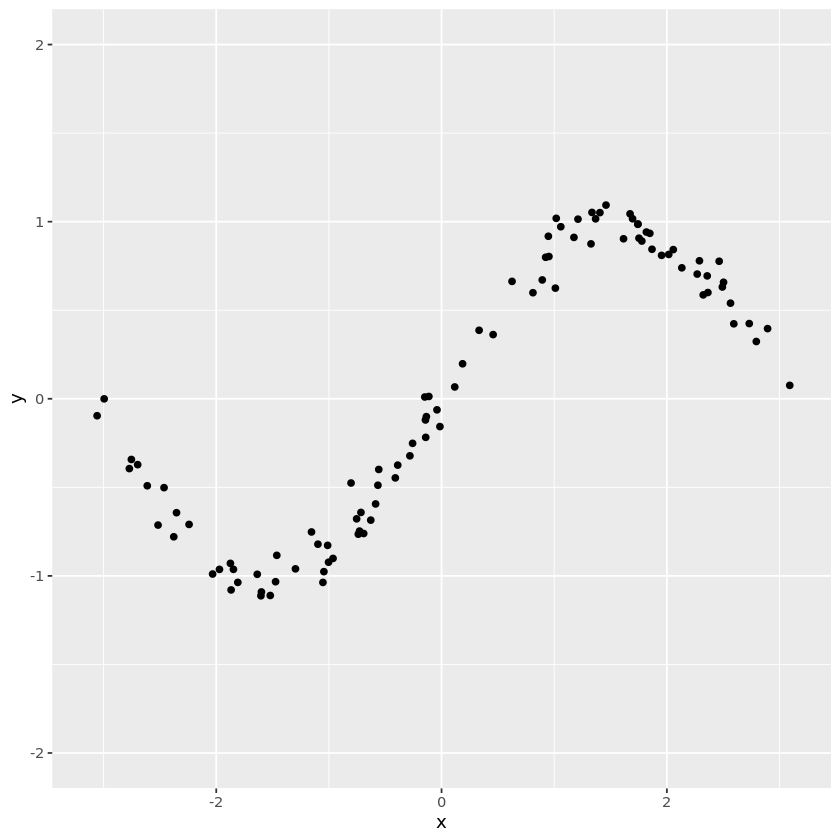

In [7]:
# サンプルデータを可視化する
graph <-
  ggplot(data = data, mapping = aes(x = x, y = y)) +
  geom_point() +
  xlim(-pi, pi) +
  ylim(-2, 2)
plot(graph)

### モデルを生成する

In [8]:
model <- cart(data = data, max_depth = 2, calc_impurity = calc_variance)

### モデルを可視化する

In [9]:
str(model)

List of 4
 $ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ variable : chr "x"
  ..$ threshold: num 0.0427
  ..$ delta    : num 0.469
 $ left :List of 4
  ..$ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ variable : chr "x"
  .. ..$ threshold: num -0.558
  .. ..$ delta    : num 0.0548
  ..$ left :List of 1
  .. ..$ pred: num -0.756
  ..$ right:List of 1
  .. ..$ pred: num -0.202
  ..$ pred : num -0.629
 $ right:List of 4
  ..$ self : tibble [1 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ variable : chr "x"
  .. ..$ threshold: num 0.567
  .. ..$ delta    : num 0.0212
  ..$ left :List of 1
  .. ..$ pred: num 0.253
  ..$ right:List of 1
  .. ..$ pred: num 0.781
  ..$ pred : num 0.737
 $ pred : num 0.0268


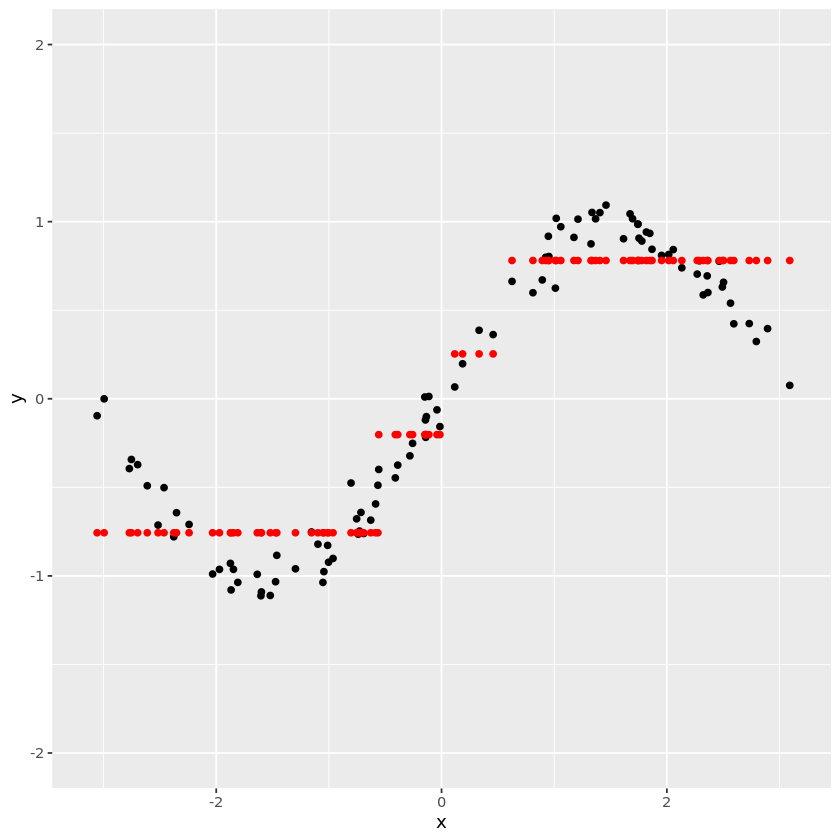

In [10]:
data$predicted <- predict(model, data)
graph <-
  ggplot() +
  geom_point(data = data, mapping = aes(x = x, y = y)) +
  geom_point(data = data, mapping = aes(x = x, y = predicted), color = "red") +
  xlim(-pi, pi) +
  ylim(-2, 2)
plot(graph)

---

## 参考文献

* [ツリーモデル(木) - Mingzhe Jin’s Home Page](https://www1.doshisha.ac.jp/~mjin/R/Chap_19/19.html)
* [決定木アルゴリズムを実装してみる - Pythonと機械学習](http://darden.hatenablog.com/entry/2016/12/15/222447)
* [Decision tree learning - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning)

---

## 動作環境

In [11]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.8.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.4     purrr_0.3.4    
[5] readr_1.4.0     tidyr_1.1.2     tibble_3.0.6    ggplot2_3.3.3  
[9] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      tidyselect_1.1.0  repr_1.1.3        haven_2.3.1      
 [5] colorspace_2.0-0  vctrs_0.3.6       